In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score ,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [2]:
news = pd.read_csv('01.csv')
news.head(5)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [3]:
news['CATEGORY'].unique() # unique category labels

array(['b', 't', 'e', 'm'], dtype=object)

(-1.101639420124838,
 1.1000780787490432,
 -1.1090927453255768,
 1.1174362845275305)

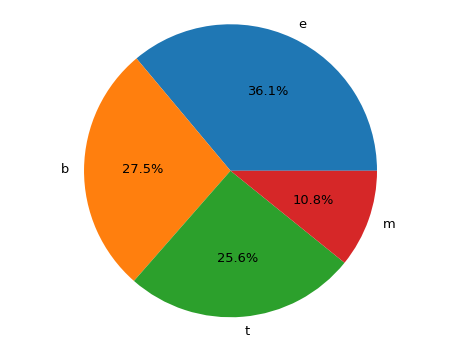

In [4]:
news.CATEGORY.value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')

In [5]:
news['TITLE'] = news['TITLE'].str.replace('[^\w\s]','').str.lower() # unpunctuate and lower case

<Figure size 432x288 with 0 Axes>

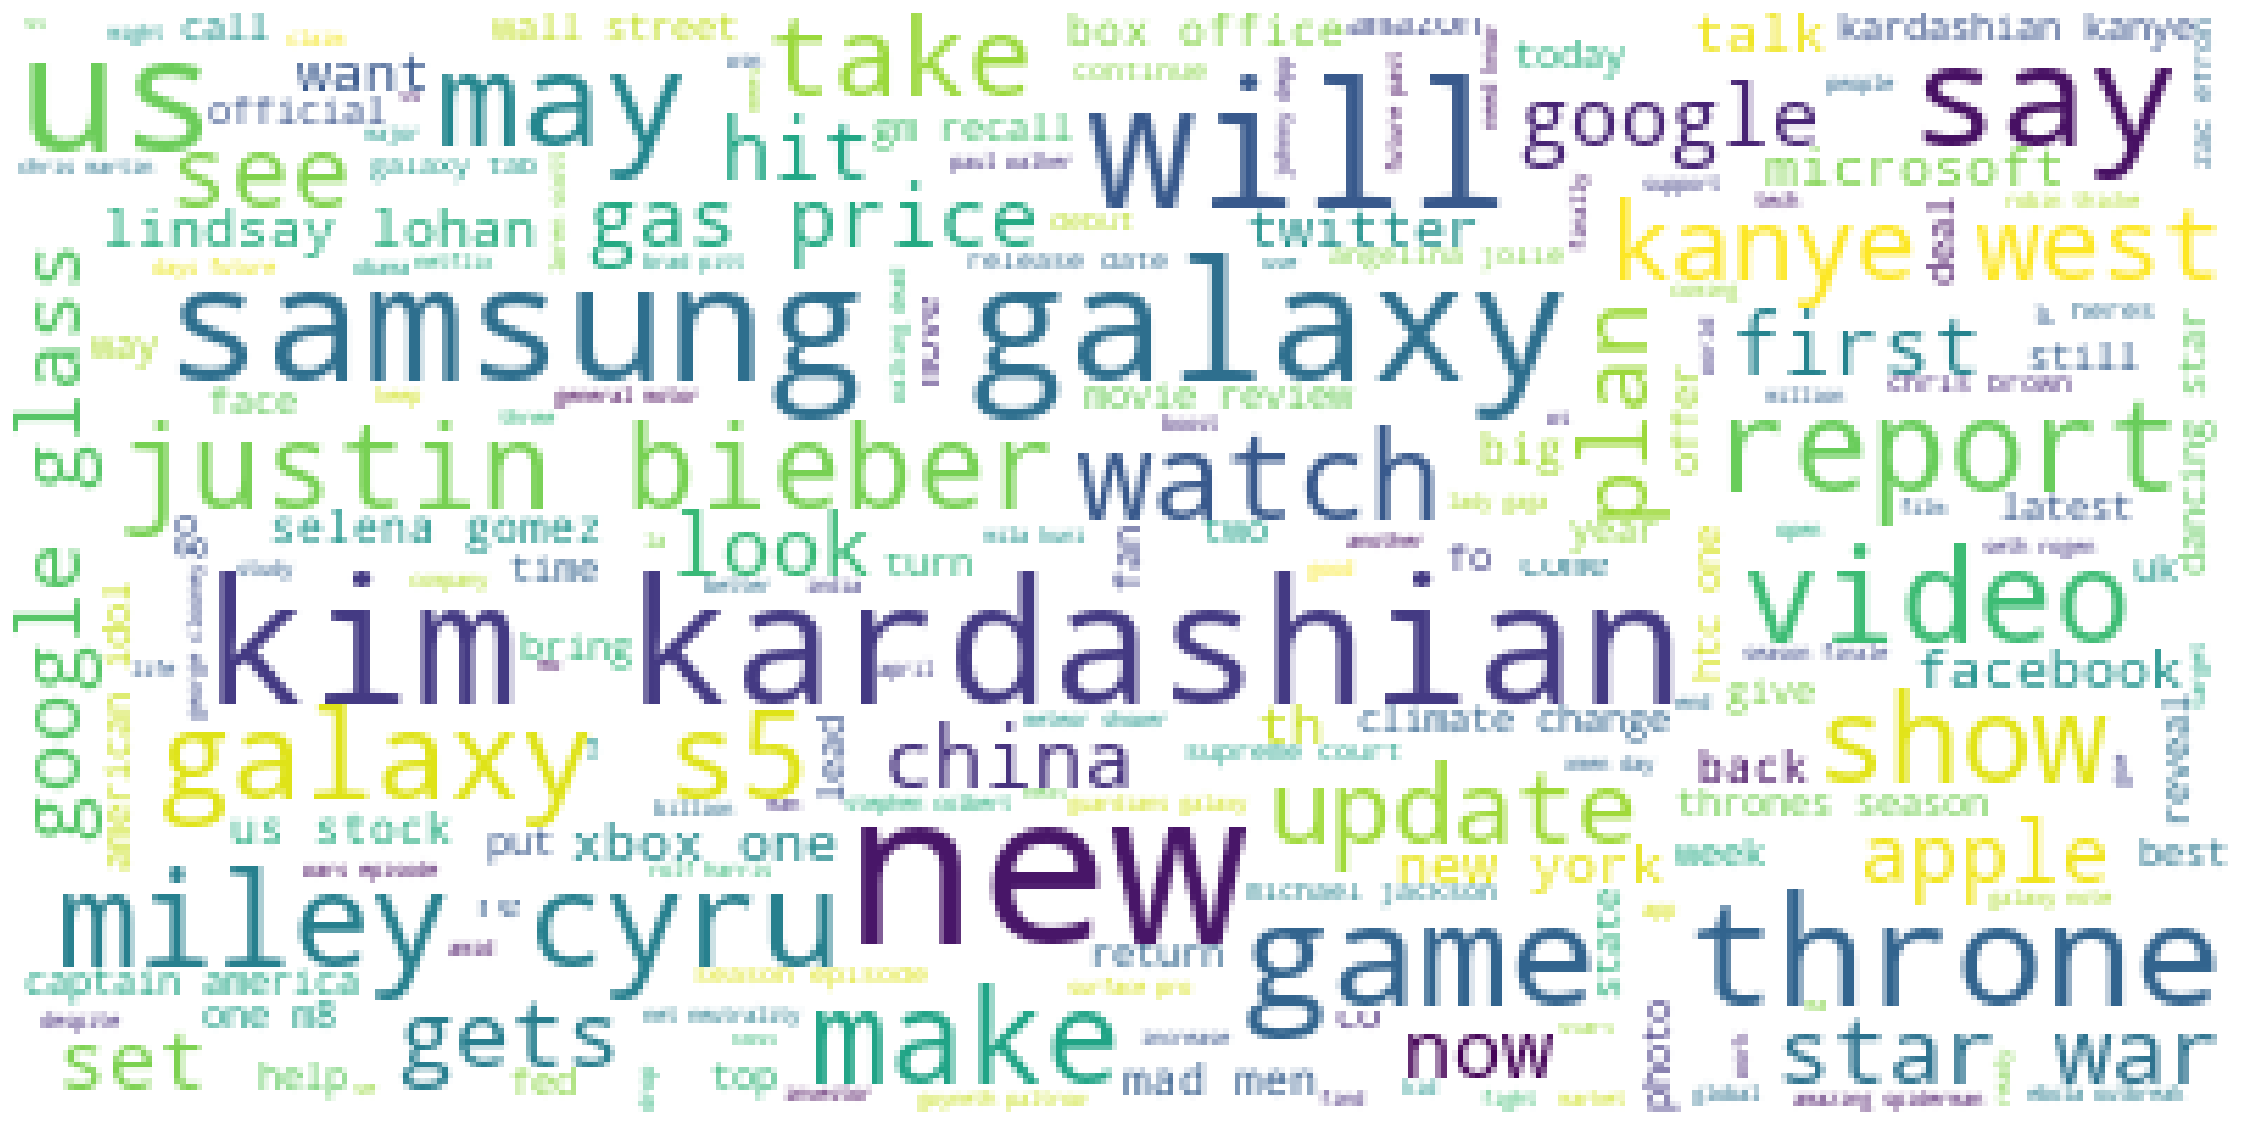

In [6]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
b_title = news['TITLE'].to_string()
#fig = plt.figure(figsize=(20,20))
stopwords = set(STOPWORDS)
wordcloud = WordCloud().generate(b_title)
plt.figure()
plt.subplots(figsize=(40,25))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(b_title),
    max_font_size=40,
    relative_scaling=.5).generate(b_title)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [7]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(news['TITLE'])
y = news['CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 30% split

In [8]:
print("n_samples: %d, n_features: %d" % X_test.shape)
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 126726, n_features: 72048
n_samples: 295693, n_features: 72048


In [9]:
dc = DummyClassifier(strategy="stratified")
dc.fit(X_train,y_train)
pred=dc.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.27      0.27      0.27     34931
           e       0.36      0.36      0.36     45623
           m       0.11      0.11      0.11     13645
           t       0.26      0.26      0.26     32527

    accuracy                           0.28    126726
   macro avg       0.25      0.25      0.25    126726
weighted avg       0.28      0.28      0.28    126726



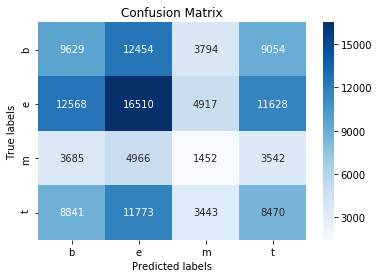

In [10]:
cf_matrix=confusion_matrix(y_test, dc.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

In [11]:
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train, y_train)
pred=mnb.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.91      0.91      0.91     34931
           e       0.97      0.96      0.97     45623
           m       0.92      0.93      0.92     13645
           t       0.90      0.91      0.91     32527

    accuracy                           0.93    126726
   macro avg       0.93      0.93      0.93    126726
weighted avg       0.93      0.93      0.93    126726



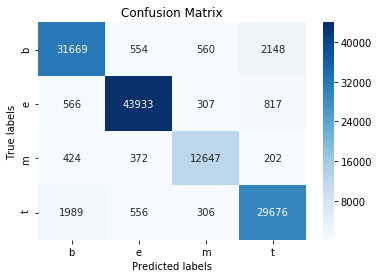

In [12]:
cf_matrix=confusion_matrix(y_test, mnb.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

In [13]:
from sklearn.svm import LinearSVC
ls=LinearSVC(dual=False,tol=1e-3)
t0 = time()
ls.fit(X_train,y_train)
train_timels = time() - t0
print("train time: %0.3fs" % train_timels)
t0 = time()
pred=ls.predict(X_test)
test_timels = time() - t0
print("test time:  %0.3fs" % test_timels)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

train time: 13.976s
test time:  0.032s
              precision    recall  f1-score   support

           b       0.92      0.93      0.92     34931
           e       0.97      0.98      0.97     45623
           m       0.95      0.93      0.94     13645
           t       0.93      0.93      0.93     32527

    accuracy                           0.95    126726
   macro avg       0.94      0.94      0.94    126726
weighted avg       0.95      0.95      0.95    126726



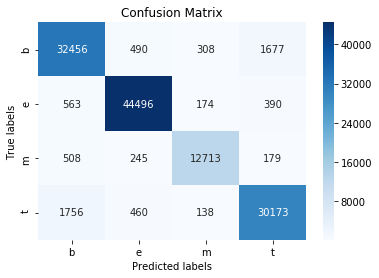

In [14]:
cf_matrix=confusion_matrix(y_test, ls.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

In [15]:
sgd=SGDClassifier(alpha=.0001, max_iter=50)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.92      0.92      0.92     34931
           e       0.96      0.98      0.97     45623
           m       0.96      0.90      0.93     13645
           t       0.92      0.92      0.92     32527

    accuracy                           0.94    126726
   macro avg       0.94      0.93      0.93    126726
weighted avg       0.94      0.94      0.94    126726



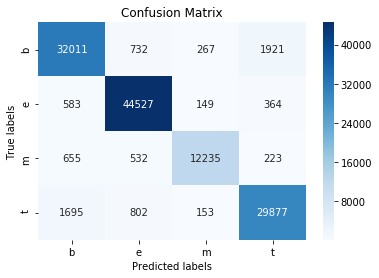

In [16]:
cf_matrix=confusion_matrix(y_test, sgd.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

In [17]:
rc=RidgeClassifier(tol=1e-2, solver="auto")
t0 = time()
rc.fit(X_train,y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)
t0 = time()
pred=rc.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

train time: 8.941s
test time:  0.034s
              precision    recall  f1-score   support

           b       0.92      0.93      0.92     34931
           e       0.96      0.98      0.97     45623
           m       0.96      0.91      0.93     13645
           t       0.93      0.93      0.93     32527

    accuracy                           0.94    126726
   macro avg       0.94      0.93      0.94    126726
weighted avg       0.94      0.94      0.94    126726



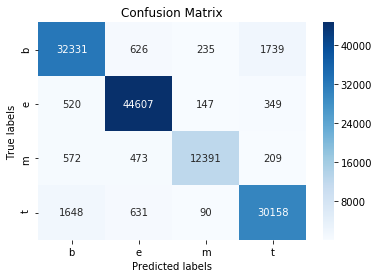

In [18]:
cf_matrix=confusion_matrix(y_test, rc.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

In [19]:
def title_to_category(title):
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter = rc.predict(vectorizer.transform([title]))
    return categories[pridicter[0]]

In [20]:
# sample predictions using our sgd classifier on 2017 BBC headlines
print('news title', '                                 ', 'category', '\n' 
      'Bank of England staff to go on strike', '      ', title_to_category('Bank of England staff to go on strike'), '\n'
      'Trump stance could damage Earth - Hawking', '  ', title_to_category('Trump stance could damage Earth - Hawking'), '\n'
      'Olivia de Havilland sues over TV show', '      ', title_to_category('Olivia de Havilland sues over TV show')
     )

news title                                   category 
Bank of England staff to go on strike        business 
Trump stance could damage Earth - Hawking    science and technology 
Olivia de Havilland sues over TV show        entertainment


In [21]:

# testing a headline from The Onion
title_to_category("OneWeb increases mega-constellation to 74 satellites")
# link to article: http://www.theonion.com/article/johnson-johnson-introduces-nothing-but-tears-shamp-2506

'business'

In [22]:
# another one from The Onion
title_to_category("Spain's coronavirus death toll jumps 514 in 24 hours")
# link to article: http://www.theonion.com/article/archaeological-dig-uncovers-ancient-race-of-skelet-932
# quote from article: "And though we know little of their language and means of communication, it is likely that they said 'boogedy-boogedy' a lot."

'health'

In [23]:
title_to_category("Burger King boss: We’re not going to pay our rent")

'business'

In [24]:
title_to_category("Taylor Swift and Kim Kardashian in war of words over leaked call")

'entertainment'